In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt


In [2]:
# Use this parameter to set printing behavior
verbose = True

In [3]:
# Compute Manhattan distance between two points
def taxicab(tup1, tup2):
    dist = 0
    for i in range(len(tup1) - 1):
        dist = dist + abs(tup1[i]-tup2[i])
    return dist

# Compute Euclidean distance between two points
def lineardist(tup1, tup2):
    dist = np.linalg.norm(np.subtract(tup1,tup2))
    return dist

In [4]:
# Median Uber user has an income of approximately $71,000
# 40% of Uber passengers make at least $100,000
# from http://uctc.net/research/papers/UCTC-FR-2014-08.pdf
# I added some high earning users, and the result is an
# approximate user distribution of incomes in 2014:

uberIncomesRaw = [25.0, 50.0, 85.0, 150.0, 300.0, 600.0]
uberIncomesDistRaw = [8.0,23.0,18.0,27.0,9.0, 2.0] 
# Note that this doesn't sum to 100, because about 20% of uber drivers
# declined to share their income with the surveyors

uberIncomes = uberIncomesRaw/(np.ones(len(uberIncomesRaw)))
# Note that these numbers are not normalized in any way
# In production, these numbers should be in units of $/minute

uberIncomesDist = uberIncomesDistRaw/np.sum(uberIncomesDistRaw)
# Force probabilities to sum to 1.

#Estimated car value of time to be equivalent to 15K/year earner
carCost = 15

In [7]:
# Compute n destinations randomly distributed away from (x,y)
# at distances proportional to stdev
def destinations(n,stdev,x, y):
    dests = []
    for i in range(n):
        dests.append(tuple(np.append(stdev*np.random.randn(2) + [x,y],(i+1))))
    return dests

# Compute and assign some random time values to n customers
# also include the time value of a car
def timevals(n):
    values = np.random.choice(uberIncomes,n,p=uberIncomesDist)
    values = np.append(carCost, values)
    return values


In [54]:
def distanceMatrix(destinations, originx, originy):
    dests1 = []
    dests1.append(tuple([originx,originy,0.0]))
    for x in destinations:
        dests1.append(x)
    A = len(dests1)
    distMatrix = np.ndarray((A, A))

    for i in range(len(distMatrix)):
        for j in range(len(distMatrix[i])):
            distMatrix[i][j] = lineardist(dests1[i],dests1[j])
    
    return distMatrix


def pathList(destinations, originx, originy):
    perms = it.permutations(destinations)
    lst = list(perms)
    np.random.shuffle(lst)

    #To reduce computation time in the case of a large number of riders,
    #We simply look at some large subset of paths instead of the entire space
    #Obviously this isn't great in the worst case, but it is good in the average case
    if len(lst) > 120:
        lst = lst[:120]
    permlist = []
    for x in lst:
        newpath = []
        newpath.append(tuple([originx,originy,0.0]))
        for j in x:
            newpath.append(j)
        permlist.append(newpath)

    return permlist

def subsetPathList(destinations, originx, originy, leftOut):
    subDests = []
    for x in destinations:
        if x[2] != leftOut:
            subDests.append(x)
            
    return pathList(subDests, originx, originy)

In [9]:
# Compute the cost of a given path given a distance matrix
# containing pairwise distances between points in the path
def costMat(weights, path, distances):
    currloc = path[0]
    currcost = 0
    for x in path:
        currcost += weights[x[2]]   
    totalcost = 0
    for i in range(len(path)):
        totalcost += currcost * distances[currloc[2]][path[i][2]]
        if i > 0:
            currcost = currcost - weights[path[i][2]]
        currloc = path[i]
    return totalcost

# Compute the environmental cost of the path, equal to
# the cost of the path to the car
def envCostMat(path, distances):
    currloc = path[0]
    currcost = carCost
    totalcost = 0
    for i in range(len(path)):
        if i > 0:
            totalcost += currcost * distances[currloc[2]][path[i][2]]
            currloc = path[i]
    return totalcost

# Computes the individual costs of a given path and returns a matrix
# with the respective costs formatted as [car, 0, 1, . . . ]
def indivCostMat(weights, path, distances):
    numPeople = riders+1
    costs = np.zeros(numPeople)
    currloc = path[0]
    totalcost = 0
    inCar = set()
    inCar.add(0)
    for n in range(len(path)):
        inCar.add(path[n][2])
    for i in range(len(path)):
        for j in inCar:
            costs[j] += weights[j]*distances[currloc[2]][path[i][2]]
            
        if i > 0: #Never removes the car
            inCar.remove(path[i][2])
        currloc = path[i]
    return costs


In [10]:
def optimalPath(weights, paths, distances):
    wgtcost =[]
    for i in range(len(paths)):
        wgtcost.append(costMat(weights,paths[i],distances))
    
    optimal = wgtcost.index(min(wgtcost))
    return optimal

def shortestPath(paths,distances):
    unwgtcost = []
    for i in range(len(paths)):
        unwgtcost.append(envCostMat(paths[i],distances))
    
    shortest =  unwgtcost.index(min(unwgtcost))
    return shortest




In [26]:
riders = 5
dispersion = 3
centerx = 100
centery = 0



In [44]:
output = []
socialcost = []
for q in range(2,6):
    output.append(np.nan) # just to beautify the graph
    socialcost.append(np.nan) # ditto
    riders = q
    for j in range(1,20):
        
        dispersion = j
        savings = []
        unsavings = []
        for i in range(400):
            vals = timevals(riders)
            #Build distance matrix
            dests = destinations(riders,dispersion,centerx,centery)
            distMatrix = distanceMatrix(dests, 0,0)
            fullPaths = pathList(dests,0,0)
            fullOpt = fullPaths[optimalPath(vals,fullPaths,distMatrix)]
            fullShort = fullPaths[shortestPath(fullPaths,distMatrix)]

            perms = it.permutations(dests)
            lst = list(perms)
            np.random.shuffle(lst)


            savings.append(costMat(vals,fullOpt,distMatrix)/costMat(vals,fullShort,distMatrix))
            unsavings.append(envCostMat(fullOpt,distMatrix)/envCostMat(fullShort,distMatrix))

        output.append(np.mean(savings))
        socialcost.append(np.mean(unsavings))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


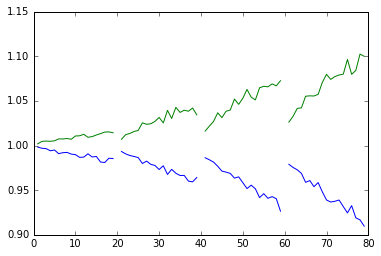

In [45]:
%matplotlib inline

#print np.mean(savings)
plt.plot(output)
plt.plot(socialcost)

In [48]:
import pickle

pickle.dump(output, open("output.txt","wb"))
pickle.dump(socialcost, open("socialcost.txt","wb"))

In [49]:
newlist = pickle.load(open("output.txt","rb"))
newlist2 = pickle.load(open("socialcost.txt","rb"))

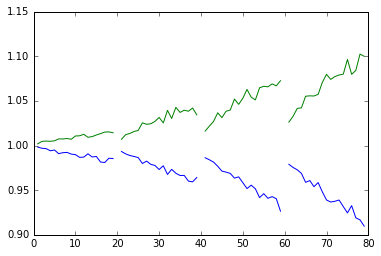

In [50]:
plt.plot(newlist)
plt.plot(newlist2)

In [53]:
assert newlist == newlist[0:len(newlist)]